# Traffic Camera: Detection and tracking


## Imports

We will start by importing a few libraries:

In [1]:
import matplotlib.pyplot as plt
import cv2

from detectionprovider import DetectionProvider
from utils import *
from yolo import YOLO

Using TensorFlow backend.


## Download 4K Traffic Cam Video

You will need **youtube-dl** to download the video. (You can ignore this step but still, you will need a video

In [ ]:
!youtube-dl -f 313 MNn9qKG2UFI

## View first frame

We will use OpenCV and Matplotlib to view the very first frame:

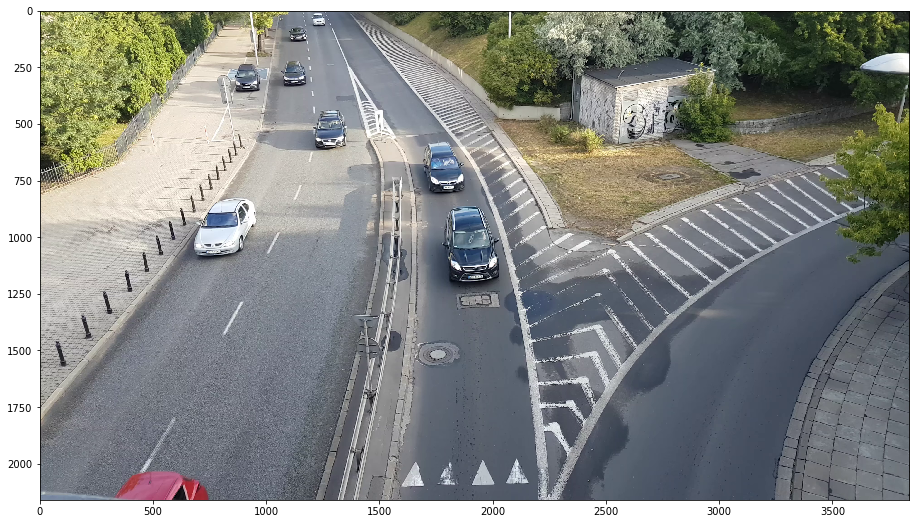

In [2]:
filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"
cap = cv2.VideoCapture(filename)
downscale = 1
while(True):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (0,0), fx=1.0 / downscale, fy=1.0 / downscale) 
    break
    
cap.release()
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

# Prepare YOLO network and generate initial bounding boxes for tracklets

In [3]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


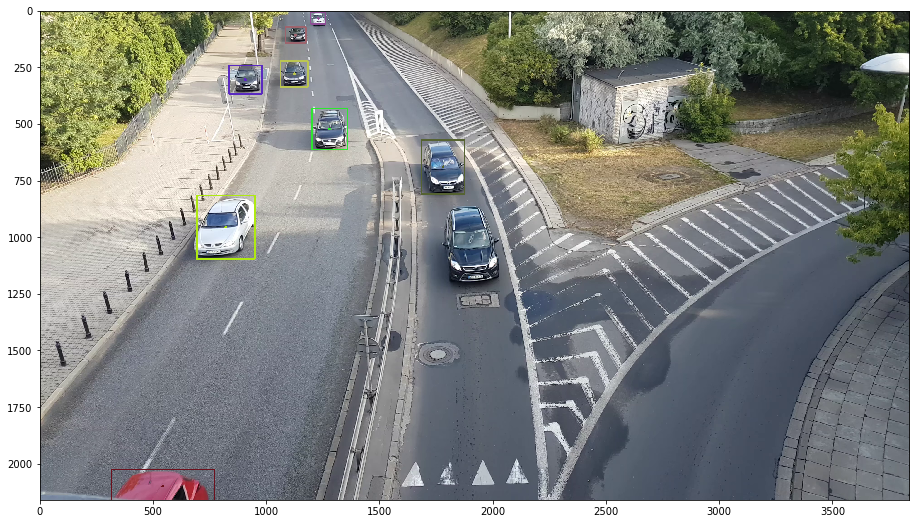

In [4]:
# params
detection_provider = DetectionProvider(yolo, min_confidence=0.8,padding=2)
boxes = detection_provider.detect_boxes(frame, 0)

for box in boxes:
     show_bbox(box["bbox"], frame, random_color(),width=5)
    
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

# Load frames and propagate through them

In [6]:
filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"
downscale = 4
cap = cv2.VideoCapture(filename)

width,height  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
output_filename = "output.avi"
out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'XVID'), fps, (width//downscale,height//downscale))

seconds_skip = 0 # number of seconds to skip
seconds_count = 5 # number of seconds to process
yolo_update = 1 # update every second

for i in range(int(fps * seconds_skip)):
    cap.grab()

frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (0,0), fx=1.0 / downscale, fy=1.0 / downscale) 

detection_provider = DetectionProvider(yolo, min_confidence=0.5,padding=0)

old_trackers, new_trackers = [], []
old_colors, new_colors = [], []

for i in range(int(fps * seconds_skip), int(fps * seconds_skip) + int(fps * seconds_count)):
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (0,0), fx=1.0 / downscale, fy=1.0 / downscale) 
    
    # detection step
    if i % int(yolo_update * fps) == 0:
        print(i)
        detections = detection_provider.detect_boxes(frame, i)
        detected_boxes = [x["bbox"] for x in detections if inside_frame(center(x["bbox"]), frame.shape, 10)]
        old_trackers += new_trackers
        
        for tracker in old_trackers:
            if tracker["color"] == (0,255,0):
                tracker["color"] = random_color()
                
        new_trackers = create_trackers(frame, detected_boxes) 
    
    # propagation step
    old_success, old_boxes = update_trackers(old_trackers, frame)  
    new_success, new_boxes = update_trackers(new_trackers,frame)
    
    # find boxes with high iou indicating that detectors may track the same item
    pairs = []
    for old_box in old_boxes:
        for new_box in new_boxes:
            if iou(old_box, new_box) > 0.3:
                i = old_boxes.index(old_box)
                j = new_boxes.index(new_box)
                new_trackers[j]["color"] = old_trackers[i]["color"]
                pairs.append( (i, j) )
    
    # removing old
    for i in sorted(list(set([x[0] for x in pairs])),reverse=True):
        old_boxes.pop(i)
        old_trackers.pop(i)
    
    # checking for exiting bboxes
    old_ids = [ i for i, old_box in enumerate(old_boxes) if not inside_frame(center(old_box), frame.shape, 10)]
    new_ids = [ i for i, new_box in enumerate(new_boxes) if not inside_frame(center(new_box), frame.shape, 10)]

    for i in sorted(old_ids,reverse=True):
        old_boxes.pop(i)
        old_trackers.pop(i)
        
    for i in sorted(new_ids,reverse=True):
        new_boxes.pop(i)
        new_trackers.pop(i)
        
    
    for i, old_box in enumerate(old_boxes):
        show_bbox(old_box, frame, old_trackers[i]["color"], width=2)
            
    for i, new_box in enumerate(new_boxes):
        show_bbox(new_box, frame, new_trackers[i]["color"], width=2)

    out.write(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))

cap.release()
out.release()

0
30
60
90
120
